In [2]:
import matplotlib.pyplot as plt
import pandas as pd

import numpy as np
from scipy.stats import chi2_contingency

In [3]:
workers = pd.read_csv('./youthPanel/refinedData/refined0.csv', encoding='ISO-8859-1')

hn4 = pd.read_csv('./youthPanel/refinedData/hn4data.csv',encoding='euc-kr')

In [4]:
workers['edu_difference'] = workers['fromWhen'] - workers['eduy']
workers_filtered = workers[(workers['edu_difference'] > -100) & (workers['edu_difference'] < 100)]

In [5]:
group_1 = workers_filtered[workers_filtered['edu_difference'] <= 0]
group_2 = workers_filtered[workers_filtered['edu_difference'] > 0]

group_1_sampids = group_1['sampid'].unique()
group_2_sampids = group_2['sampid'].unique()

group_1_a065 = hn4[hn4['sampid'].isin(group_1_sampids)]['a538']
group_2_a065 = hn4[hn4['sampid'].isin(group_2_sampids)]['a538']

group_1_a065_counts = group_1_a065.value_counts().sort_index()
group_2_a065_counts = group_2_a065.value_counts().sort_index()

### Chi-square test

In [6]:
# Define the function to perform chi-square test
def perform_chi2_test(group_1_data, group_2_data):
    combined_data = pd.concat([group_1_data, group_2_data])
    contingency_table = pd.crosstab(combined_data.index, combined_data.values)
    if contingency_table.size == 0:
        raise ValueError("Contingency table is empty")
    chi2, p, dof, expected = chi2_contingency(contingency_table)
    return chi2, p


p-value >= 0.05:
  Column        Chi2   p-value  Group 1 Count  Group 2 Count Error
0   a029  162.619679  0.125080           1679            876      
1  a029z   13.321440  0.714416           1679            876      
2   a031   11.351059  0.182590           1642            865      
3   a032    3.860017  0.145147             37             11      
4   a033    4.195156  0.241147             37             11      

p-value < 0.05:
   Column       Chi2       p-value  Group 1 Count  Group 2 Count Error
5    a034  56.326110  6.800141e-09           1679            876      
17   a046  10.538012  3.227739e-02           1117            606      
32   a075   3.848882  4.977916e-02           1486            783      
48   a092  11.567914  4.121280e-02            138             74      
81   a224   5.028827  2.492878e-02            848            423      

Insufficient data or other errors:
   Column  Chi2  p-value  Group 1 Count  Group 2 Count  \
72   a118   NaN      NaN              3     

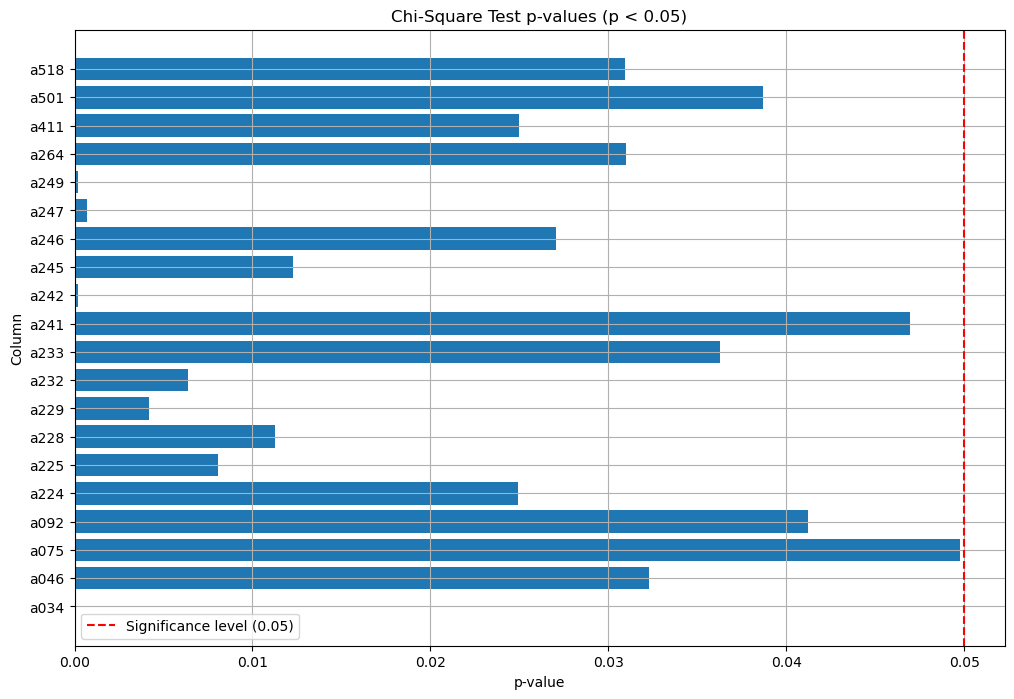

In [7]:
# Extract unique sampids from each group
group_1_sampids = group_1['sampid'].unique()
group_2_sampids = group_2['sampid'].unique()

# Select columns to perform chi-square test on, excluding 'sampid'
columns_to_test = hn4.columns.difference(['sampid'])

# Store results
chi2_results = []

for column in columns_to_test:
    try:
        # Drop NA values for the current column
        group_1_data = hn4[hn4['sampid'].isin(group_1_sampids)][column].dropna()
        group_2_data = hn4[hn4['sampid'].isin(group_2_sampids)][column].dropna()
        
        # Ensure both groups have data
        if not group_1_data.empty and not group_2_data.empty:
            # Assign group labels
            group_1_data.index = ['group_1'] * len(group_1_data)
            group_2_data.index = ['group_2'] * len(group_2_data)
            
            chi2, p = perform_chi2_test(group_1_data, group_2_data)
            chi2_results.append({
                'Column': column,
                'Chi2': chi2,
                'p-value': p,
                'Group 1 Count': len(group_1_data),
                'Group 2 Count': len(group_2_data),
                'Error': ''
            })
        else:
            chi2_results.append({
                'Column': column,
                'Chi2': np.nan,
                'p-value': np.nan,
                'Group 1 Count': len(group_1_data),
                'Group 2 Count': len(group_2_data),
                'Error': 'Insufficient data in one of the groups'
            })
    except Exception as e:
        chi2_results.append({
            'Column': column,
            'Chi2': np.nan,
            'p-value': np.nan,
            'Group 1 Count': len(group_1_data) if 'group_1_data' in locals() else 0,
            'Group 2 Count': len(group_2_data) if 'group_2_data' in locals() else 0,
            'Error': str(e)
        })
        print(f"An error occurred with column {column}: {e}")

# Convert results to DataFrame
chi2_results_df = pd.DataFrame(chi2_results)

# Split the results into three categories
p_above_0_05 = chi2_results_df[(chi2_results_df['p-value'] >= 0.05) & (chi2_results_df['Error'] == '')]
p_below_0_05 = chi2_results_df[(chi2_results_df['p-value'] < 0.05) & (chi2_results_df['Error'] == '')]
insufficient_data = chi2_results_df[chi2_results_df['Error'] != '']

# Display the results
print("p-value >= 0.05:")
print(p_above_0_05.head())
print("\np-value < 0.05:")
print(p_below_0_05.head())
print("\nInsufficient data or other errors:")
print(insufficient_data.head())

# Optionally save to a CSV file
chi2_results_df.to_csv('chi_square_test_results.csv', index=False)

# Plotting the p-values for better visualization
if not p_below_0_05.empty:
    plt.figure(figsize=(12, 8))
    plt.barh(p_below_0_05['Column'], p_below_0_05['p-value'])
    plt.axvline(x=0.05, color='r', linestyle='--', label='Significance level (0.05)')
    plt.xlabel('p-value')
    plt.ylabel('Column')
    plt.title('Chi-Square Test p-values (p < 0.05)')
    plt.legend()
    plt.grid(True)
    plt.show()
else:
    print("No valid results with p-value < 0.05 to display.")

In [8]:
# 컬럼 리스트 준비
column_names = [
    '전공계열', '학교생활만족도8-취업가능성', '전과여부', '수능백분위-사탐',
    '취업노력2-직업적성검사', '취업노력3-면접훈련', '취업노력6-선생님께부탁',
    '취업노력7-정보지구인란구독', '취업노력10-이력서제출', '취업노력11-그룹스터디',
    '장래희망직업여부', '직업분야', '희망직업코드', '희망직업선택이유',
    '희망직업산업', '취업희망기업', '직업선택시중요도13-자율', '휴학사유',
    '아르바이트경험여부', '아르바이트이유'
]

# 주어진 컬럼 리스트를 p_below_0_05의 새로운 'column_name' 열에 추가
# p_below_0_05의 길이가 column_names보다 길면, NaN으로 채우기 위해 fillna를 사용함
p_below_0_05 = p_below_0_05.reset_index(drop=True)
p_below_0_05['column_name'] = pd.Series(column_names).reindex(p_below_0_05.index).fillna(value='No name available')

# 결과 출력
print(p_below_0_05)

   Column        Chi2       p-value  Group 1 Count  Group 2 Count Error  \
0    a034   56.326110  6.800141e-09           1679            876         
1    a046   10.538012  3.227739e-02           1117            606         
2    a075    3.848882  4.977916e-02           1486            783         
3    a092   11.567914  4.121280e-02            138             74         
4    a224    5.028827  2.492878e-02            848            423         
5    a225    7.018371  8.067758e-03            848            423         
6    a228    6.426339  1.124401e-02            742            378         
7    a229    8.196700  4.196664e-03            848            423         
8    a232    7.432550  6.405450e-03            848            423         
9    a233    4.384225  3.627297e-02            848            423         
10   a241    3.946678  4.696400e-02           1277            658         
11   a242   30.112533  2.019114e-04            572            292         
12   a245  239.866973  1.

In [9]:
selected_columns = ['a034','a039','a041','a045','a075','a225','a228','a229','a232','a233','a266','a362','a242','a247','a249','a254','a264','a501']
selected = p_below_0_05.loc[p_below_0_05['Column'].isin(selected_columns)]
print(selected)

   Column       Chi2       p-value  Group 1 Count  Group 2 Count Error  \
0    a034  56.326110  6.800141e-09           1679            876         
2    a075   3.848882  4.977916e-02           1486            783         
5    a225   7.018371  8.067758e-03            848            423         
6    a228   6.426339  1.124401e-02            742            378         
7    a229   8.196700  4.196664e-03            848            423         
8    a232   7.432550  6.405450e-03            848            423         
9    a233   4.384225  3.627297e-02            848            423         
11   a242  30.112533  2.019114e-04            572            292         
14   a247  35.438910  7.246781e-04           1277            658         
15   a249  30.443332  1.764306e-04           1277            658         
16   a264  12.292219  3.099583e-02           1277            658         
18   a501   4.274063  3.869830e-02           1661            874         

       column_name  
0             전공

In [10]:
plt.rcParams['font.family'] ='Malgun Gothic'
plt.rcParams['axes.unicode_minus'] = False

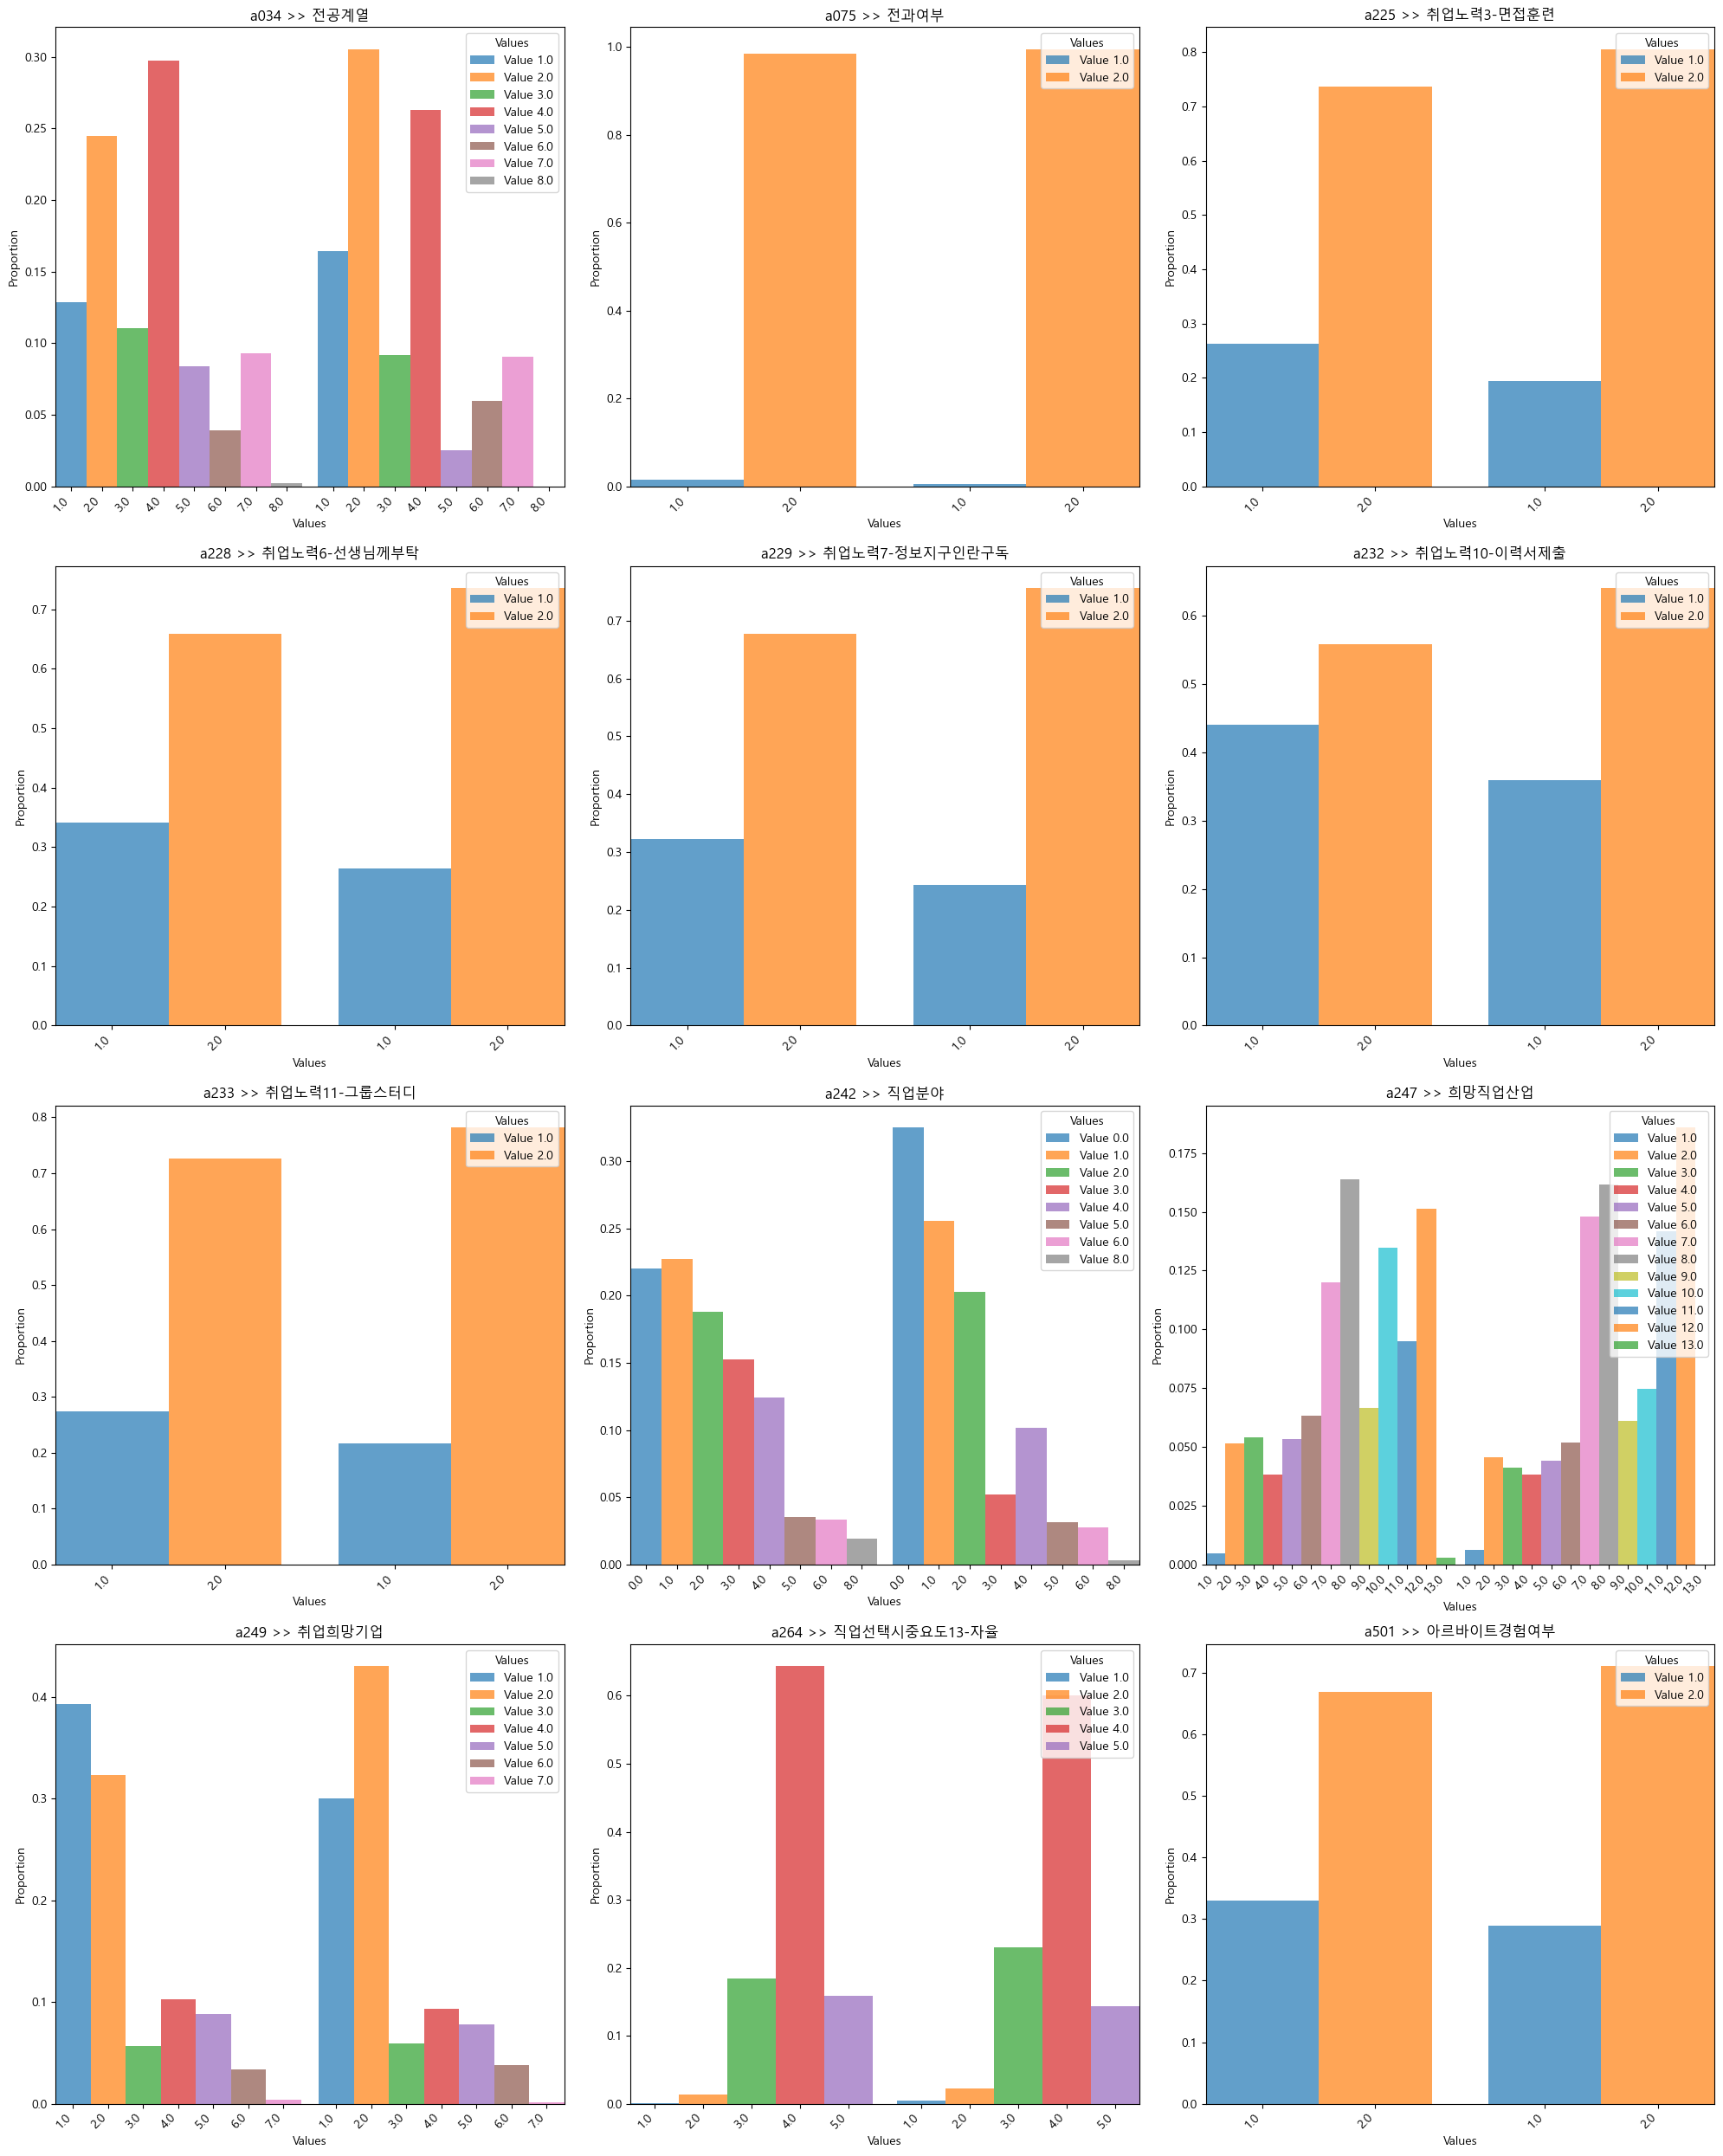

In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# 컬럼명을 시각화할 목록으로 설정합니다.
columns_to_visualize = selected['Column'].tolist()

# hn4에 존재하는 컬럼만 추출합니다.
existing_columns = [col for col in columns_to_visualize if col in hn4.columns]

# 필요한 subplot의 개수를 계산합니다.
num_plots = len(existing_columns)
num_cols = 3
num_rows = int(np.ceil(num_plots / num_cols))  # 필요한 행의 개수를 계산합니다.

# subplot을 생성합니다.
fig, axes = plt.subplots(num_rows, num_cols, figsize=(20, 25))
axes = axes.flatten()  # 축 배열을 평탄화하여 쉽게 인덱싱할 수 있도록 합니다.

# 각 컬럼의 데이터를 시각화합니다.
for i, column in enumerate(existing_columns):
    ax = axes[i]
    
    # 두 그룹의 데이터를 가져오고 아웃라이어를 필터링합니다.
    group_1_data = hn4[hn4['sampid'].isin(group_1_sampids)][column].dropna()
    group_2_data = hn4[hn4['sampid'].isin(group_2_sampids)][column].dropna()
    
    # 아웃라이어를 필터링합니다.
    group_1_data_filtered = group_1_data[(group_1_data >= -90) & (group_1_data <= 90)]
    group_2_data_filtered = group_2_data[(group_2_data >= -90) & (group_2_data <= 90)]
    
    # 값의 개수를 계산합니다.
    group_1_counts = group_1_data_filtered.value_counts().sort_index()
    group_2_counts = group_2_data_filtered.value_counts().sort_index()
    
    # 비율을 계산합니다.
    group_1_proportions = group_1_counts / group_1_counts.sum()
    group_2_proportions = group_2_counts / group_2_counts.sum()
    
    # 두 그룹의 인덱스를 정렬하여 막대가 나란히 배치되도록 합니다.
    all_indices = group_1_counts.index.union(group_2_counts.index)
    group_1_proportions = group_1_proportions.reindex(all_indices, fill_value=0)
    group_2_proportions = group_2_proportions.reindex(all_indices, fill_value=0)

    # 각 막대의 너비 및 위치를 정의합니다.
    num_values = len(all_indices)
    bar_width = 1.0
    gap_between_groups = 0.5  # 그룹 간의 간격

    # Group 1과 Group 2의 막대 위치를 정의합니다.
    bar_positions_1 = np.arange(num_values)
    bar_positions_2 = bar_positions_1 + num_values + gap_between_groups

    # 각 값이 고유한 색상을 갖도록 컬러 맵을 생성합니다.
    cmap = plt.get_cmap('tab10')  # 10개의 색상을 가진 컬러 맵을 사용합니다.
    colors = [cmap(i % cmap.N) for i in range(num_values)]

    # 두 그룹에 대해 겹치지 않도록 막대를 시각화합니다.
    bars1 = ax.bar(bar_positions_1, group_1_proportions, width=bar_width, alpha=0.7, color=colors, label='Group 1')
    bars2 = ax.bar(bar_positions_2, group_2_proportions, width=bar_width, alpha=0.7, color=colors, label='Group 2')
    
    
    # subplot의 제목을 'Column-Column_name' 형식으로 설정합니다.
    column_name = selected.loc[selected['Column'] == column, 'column_name'].values[0]
    ax.set_title(f"{column} >> {column_name}")

    # 클러스터와 값을 위한 라벨을 추가합니다.
    ax.set_xticks(np.concatenate([bar_positions_1, bar_positions_2]))
    ax.set_xticklabels([f"{val}" for val in all_indices] * 2, rotation=45, ha='right')
    
    # 범례를 각 값에 대한 색상으로 설정합니다.
    legend_labels = [f"Value {val}" for val in all_indices]
    ax.legend(bars1, legend_labels, loc='upper right', title='Values')

    ax.set_xlabel('Values')  # 'Groups and Values' 대신 'Values'로 설정합니다.
    ax.set_ylabel('Proportion')
    ax.set_xlim([-0.5, bar_positions_2[-1] + 0.5])  # X축 범위를 설정하여 클러스터 간의 격차를 설정합니다.

# 사용되지 않은 subplot을 제거합니다.
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

# 레이아웃을 조정합니다.
plt.tight_layout()
plt.show()


In [12]:
print(len(group_1_sampids))
print(len(group_2_sampids))

3069
2372


In [13]:
# 컬럼명을 시각화할 목록으로 설정합니다.
columns_to_visualize = selected['Column'].tolist()

# hn4에 존재하는 컬럼만 추출합니다.
existing_columns = [col for col in columns_to_visualize if col in hn4.columns]

# Group 1과 Group 2의 데이터를 저장할 빈 데이터프레임을 생성합니다.
group_1_df = pd.DataFrame(index=hn4.index)
group_2_df = pd.DataFrame(index=hn4.index)

# 각 컬럼의 데이터를 시각화하고 데이터프레임에 저장합니다.
for column in existing_columns:
    # 두 그룹의 데이터를 가져오고 아웃라이어를 필터링합니다.
    group_1_data = hn4[hn4['sampid'].isin(group_1_sampids)][column].dropna()
    group_2_data = hn4[hn4['sampid'].isin(group_2_sampids)][column].dropna()

    # 아웃라이어를 필터링합니다.
    group_1_data_filtered = group_1_data[(group_1_data >= -90) & (group_1_data <= 90)]
    group_2_data_filtered = group_2_data[(group_2_data >= -90) & (group_2_data <= 90)]

    # 데이터를 데이터프레임에 추가합니다.
    group_1_df[column] = group_1_data_filtered
    group_2_df[column] = group_2_data_filtered

# print(group_1_df.head(20))
print(group_2_df.head(20))

    a034  a075  a225  a228  a229  a232  a233  a242  a247  a249  a264  a501
0    NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN
1    NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN
2    NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN
3    NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN
4    NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN
5    NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN
6    NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN
7    NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN
8    NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN
9    NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN
10   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN
11   2.0   2.0   2.0   2.0   2.0   2.0   2.0   NaN   7.0   2.0   3.0   2.0
12   NaN   NaN   NaN   Na

#### 태블로 전처리

In [14]:
hn4.head()

,sampid,when4hn,a029,a029z,a031,a032,a033,a034,a035,a036,...,a591,a592,a593,a594,a595,a596,a597,a598,a599,a600
0,1,2014.0,1402.0,14.0,1.0,NaN,NaN,4.0,조경학과,U04010300006,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,NaN,2.0
1,2,2016.0,813.0,8.0,1.0,NaN,NaN,7.0,미디어학과,U02030500029,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,1.0,2.0
2,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,2007.0,901.0,9.0,1.0,NaN,NaN,2.0,경영학과,U02010100035,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [15]:
# 새로운 데이터프레임 생성
new_df = pd.DataFrame(hn4['sampid'])

# 취업까지 걸린 시간 변수 추가
new_df['취업까지_걸린_시간'] = new_df['sampid'].apply(lambda x: '1년 미만' if x in group_1_sampids else '1년 이상' if x in group_2_sampids else 'N/A')

In [115]:
# N/A 행 제거
new_df = new_df[new_df['취업까지_걸린_시간'] != 'N/A']
# new_df.head(20)
# len(new_df)

In [113]:
print(selected_columns)

['a034', 'a075', 'a225', 'a228', 'a229', 'a232', 'a233', 'a242', 'a247', 'a249', 'a264', 'a501']


In [116]:
# selected_columns에 있는 변수들을 new_df에 추가
new_df = new_df.merge(hn4[['sampid'] + selected_columns], on='sampid', how='left')

new_df.head(20)

,sampid,취업까지_걸린_시간,a034,a075,a225,a228,a229,a232,a233,a242,a247,a249,a264,a501
0,1,1년 미만,4.0,2.0,2.0,1.0,1.0,1.0,2.0,NaN,3.0,2.0,4.0,1.0
1,2,1년 미만,7.0,2.0,2.0,1.0,2.0,1.0,2.0,NaN,8.0,3.0,4.0,1.0
2,10,1년 미만,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,12,1년 이상,2.0,2.0,2.0,2.0,2.0,2.0,2.0,NaN,7.0,2.0,3.0,2.0
4,13,1년 미만,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,14,1년 미만,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,15,1년 이상,4.0,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0
7,19,1년 미만,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,21,1년 미만,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,22,1년 미만,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [133]:
# selected_columns의 값이 -90에서 90을 벗어나는 경우 NaN으로 설정
for col in selected_columns:
    # 극단값 및 inf를 NaN으로 설정
    new_df[col] = new_df[col].apply(lambda x: x if -90 <= x <= 90 else np.nan)
    new_df[col] = new_df[col].dropna().astype('Int64').replace(0, np.nan)

new_df.head(20)

,sampid,취업까지_걸린_시간,a034,a075,a225,a228,a229,a232,a233,a242,a247,a249,a264,a501
0,1,1년 미만,4,2,2,1,1,1,2,<NA>,3,2,4,1
1,2,1년 미만,7,2,2,1,2,1,2,<NA>,8,3,4,1
2,10,1년 미만,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>
3,12,1년 이상,2,2,2,2,2,2,2,<NA>,7,2,3,2
4,13,1년 미만,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>
5,14,1년 미만,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>
6,15,1년 이상,4,2,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,2
7,19,1년 미만,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>
8,21,1년 미만,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>
9,22,1년 미만,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>


In [135]:
# 컬럼명을 새로운 변수명으로 변경
new_df.rename(columns={
    'a034': '전공계열',
    'a075': '전과여부',
    'a225': '취업노력3_면접훈련',
    'a228': '취업노력6_선생님에게_취업부탁',
    'a229': '취업노력7_정보지구인란_구독',
    'a232': '취업노력10_이력서_제출',
    'a233': '취업노력11_그룹스터디',
    'a242': '직업선택시_중요도13_자율',
    'a247': '휴학사유',
    'a249': '아르바이트_경험_여부',
    'a264': '취업희망기업',
    'a501': '아르바이트_이유'
}, inplace=True)

new_df.head(20)

,sampid,취업까지_걸린_시간,전공계열,전과여부,취업노력3_면접훈련,취업노력6_선생님에게_취업부탁,취업노력7_정보지구인란_구독,취업노력10_이력서_제출,취업노력11_그룹스터디,직업선택시_중요도13_자율,휴학사유,아르바이트_경험_여부,취업희망기업,아르바이트_이유
0,1,1년 미만,4,2,2,1,1,1,2,<NA>,3,2,4,1
1,2,1년 미만,7,2,2,1,2,1,2,<NA>,8,3,4,1
2,10,1년 미만,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>
3,12,1년 이상,2,2,2,2,2,2,2,<NA>,7,2,3,2
4,13,1년 미만,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>
5,14,1년 미만,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>
6,15,1년 이상,4,2,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,2
7,19,1년 미만,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>
8,21,1년 미만,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>
9,22,1년 미만,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>


In [137]:
new_df.to_excel('worktime4tableau.xlsx', index=False)

#### 데이터 분석

In [16]:
group_1_data = hn4[hn4['sampid'].isin(group_1_sampids)].dropna()

In [17]:
group_1_data.head()

,sampid,when4hn,a029,a029z,a031,a032,a033,a034,a035,a036,...,a591,a592,a593,a594,a595,a596,a597,a598,a599,a600


In [18]:
group_2_data_filtered.shape

(874,)

NameError: name 'v' is not defined

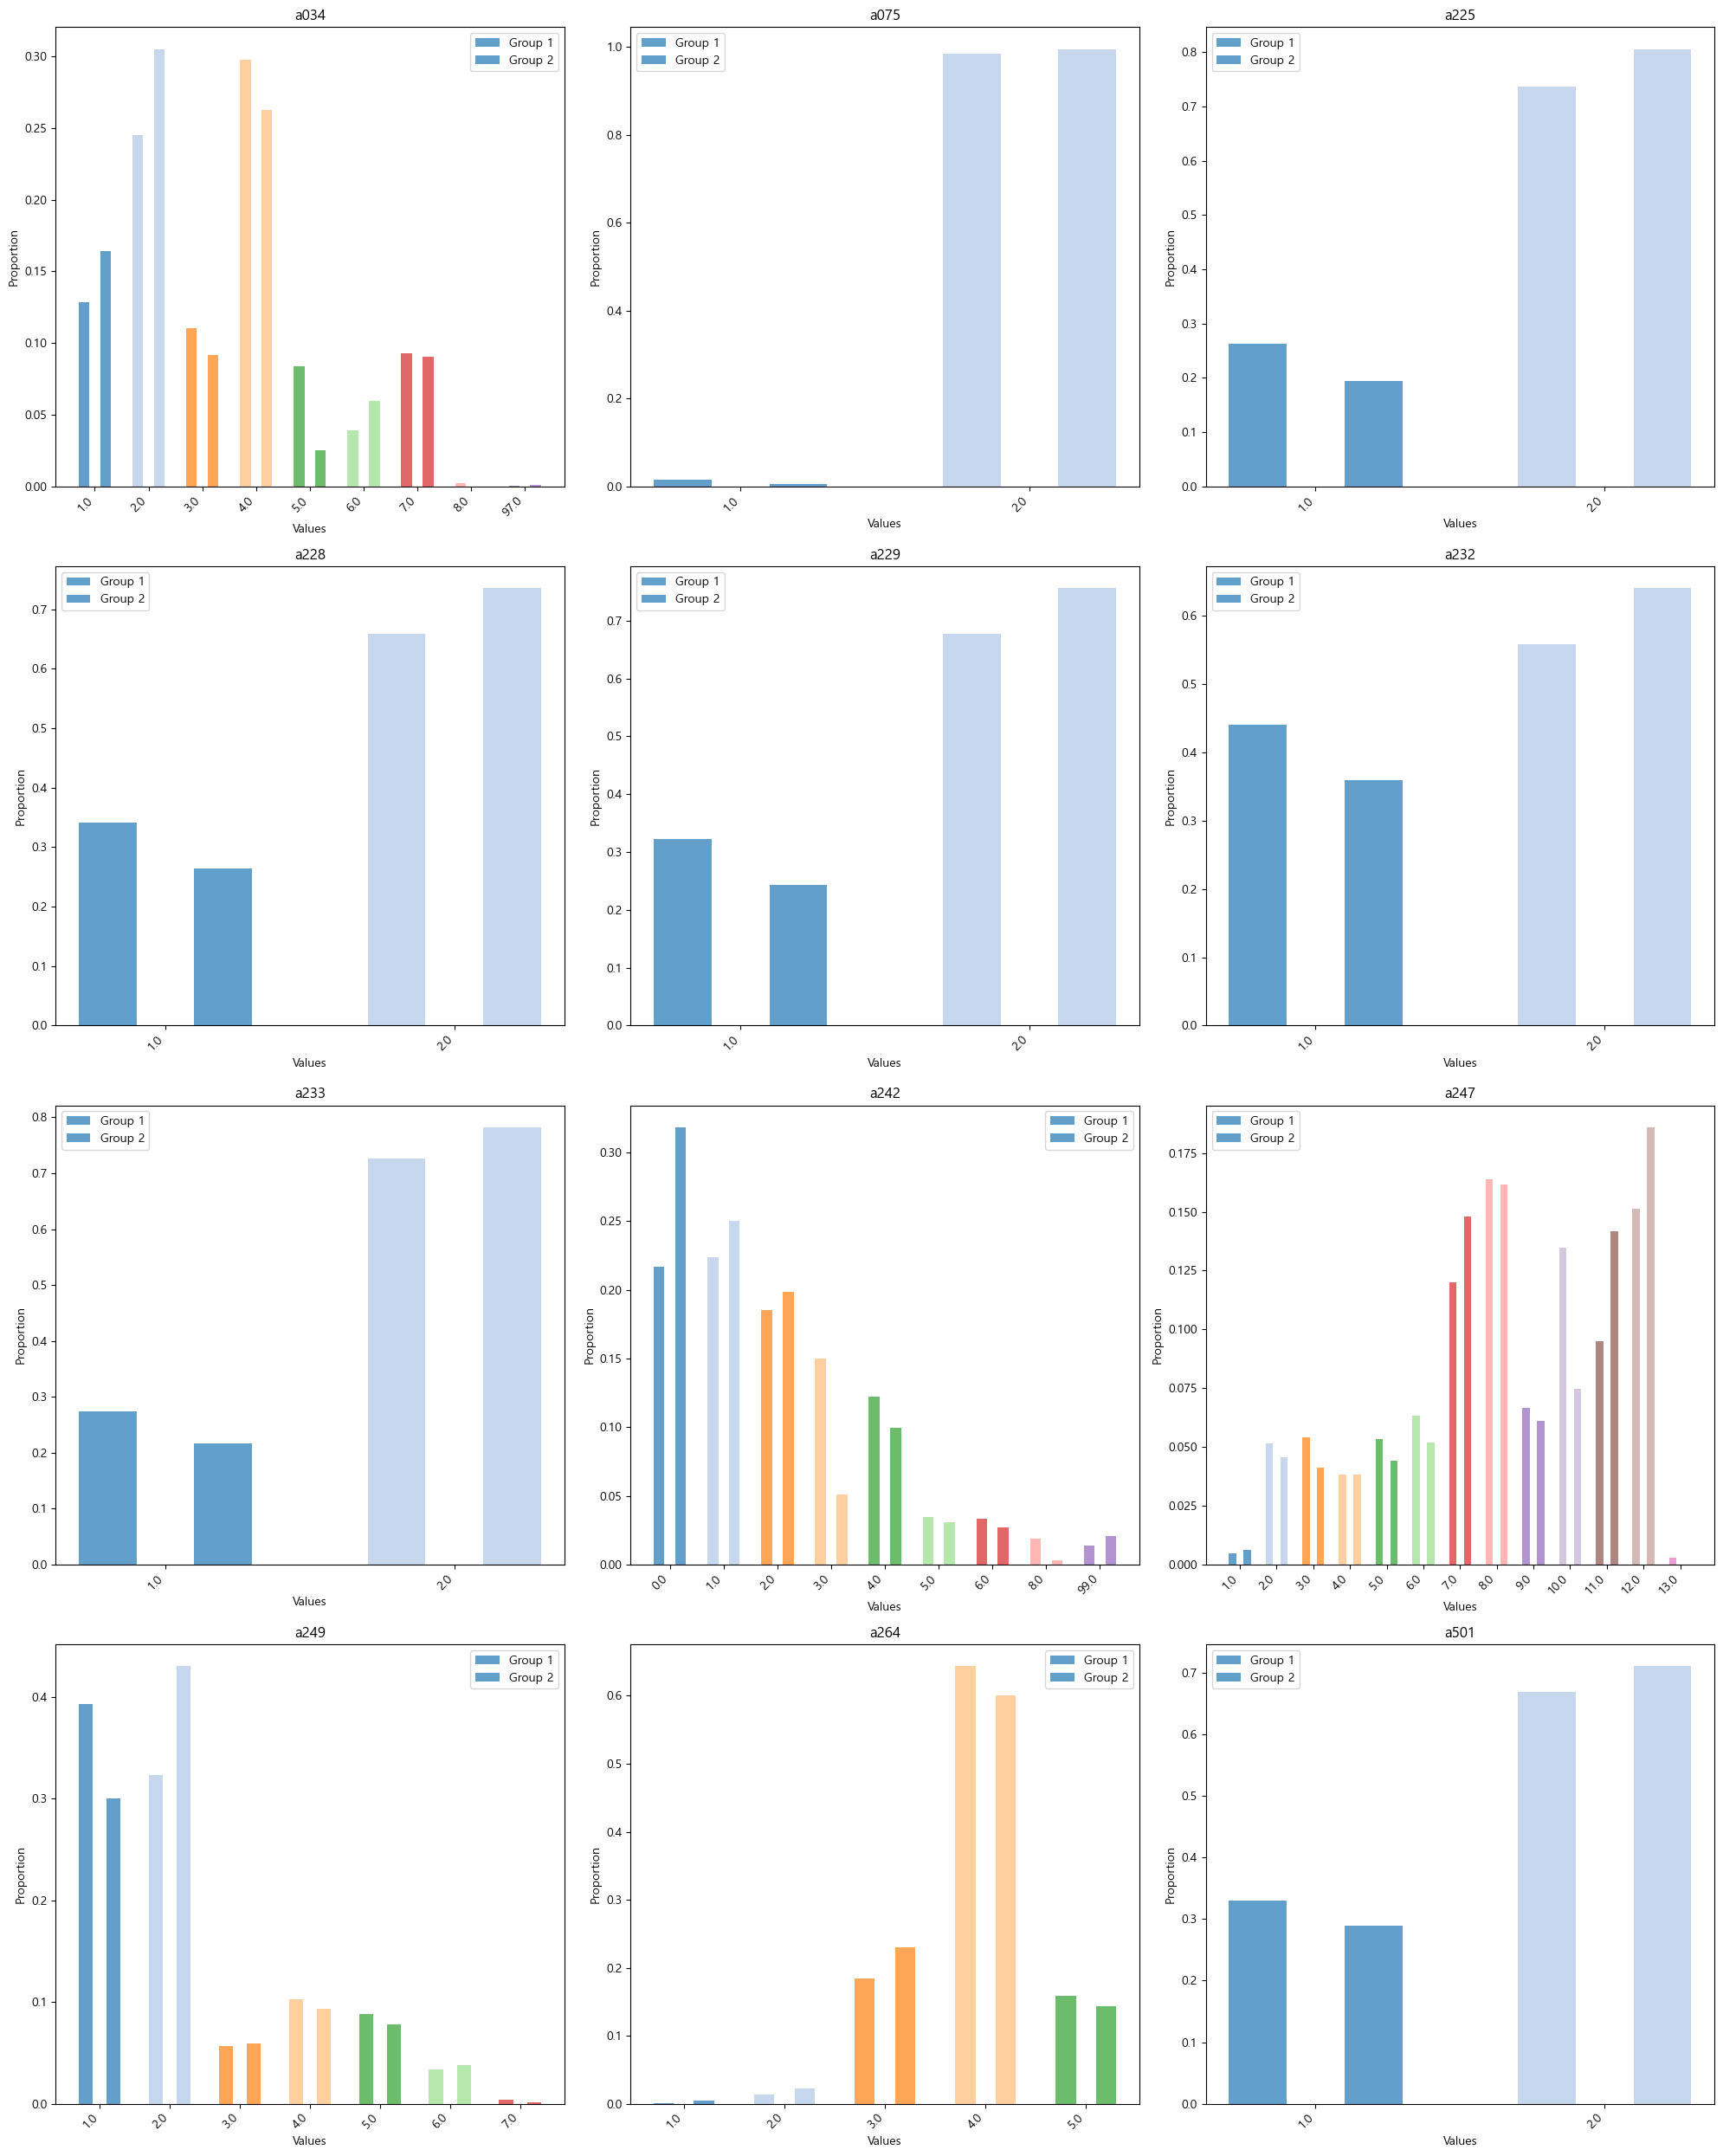

In [19]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# 컬럼명을 시각화할 목록으로 설정합니다.
columns_to_visualize = selected['Column'].tolist()

# hn4에 존재하는 컬럼만 추출합니다.
existing_columns = [col for col in columns_to_visualize if col in hn4.columns]

# 필요한 subplot의 개수를 계산합니다.
num_plots = len(existing_columns)
num_cols = 3
num_rows = int(np.ceil(num_plots / num_cols))  # 필요한 행의 개수를 계산합니다.

# subplot을 생성합니다.
fig, axes = plt.subplots(num_rows, num_cols, figsize=(20, 25))
axes = axes.flatten()  # 축 배열을 평탄화하여 쉽게 인덱싱할 수 있도록 합니다.

# 각 컬럼의 데이터를 시각화합니다.
for i, column in enumerate(existing_columns):
    ax = axes[i]
    
    # 두 그룹의 데이터를 가져오고 아웃라이어를 필터링합니다.
    group_1_data = hn4[hn4['sampid'].isin(group_1_sampids)][column].dropna()
    group_2_data = hn4[hn4['sampid'].isin(group_2_sampids)][column].dropna()
    
    # 아웃라이어를 필터링합니다.
    group_1_data_filtered = group_1_data[(group_1_data >= -100) & (group_1_data <= 100)]
    group_2_data_filtered = group_2_data[(group_2_data >= -100) & (group_2_data <= 100)]
    
    # 값의 개수를 계산합니다.
    group_1_counts = group_1_data_filtered.value_counts().sort_index()
    group_2_counts = group_2_data_filtered.value_counts().sort_index()
    
    # 비율을 계산합니다.
    group_1_proportions = group_1_counts / group_1_counts.sum()
    group_2_proportions = group_2_counts / group_2_counts.sum()
    
    # 두 그룹의 인덱스를 정렬하여 막대가 나란히 배치되도록 합니다.
    all_indices = group_1_counts.index.union(group_2_counts.index)
    group_1_proportions = group_1_proportions.reindex(all_indices, fill_value=0)
    group_2_proportions = group_2_proportions.reindex(all_indices, fill_value=0)

    # 각 막대의 너비 및 위치를 정의합니다.
    num_values = len(all_indices)
    bar_width = 0.4
    bar_positions = np.arange(num_values)  # Create a position array for each group's data

    # 각 값이 고유한 색상을 갖도록 컬러 맵을 생성합니다.
    cmap = plt.get_cmap('tab20')  # 20개의 색상을 가진 컬러 맵을 사용합니다.
    colors = [cmap(i) for i in range(num_values)]

    # 두 그룹에 대해 겹치지 않도록 막대를 시각화합니다.
    ax.bar(bar_positions - bar_width/2, group_1_proportions, width=bar_width / 2, label='Group 1', alpha=0.7, color=colors)
    ax.bar(bar_positions + bar_width/2, group_2_proportions, width=bar_width / 2, label='Group 2', alpha=0.7, color=colors)
    
    # 값을 위한 라벨을 추가합니다.
    ax.set_xticks(bar_positions)
    ax.set_xticklabels(all_indices, rotation=45, ha='right')
    ax.set_title(column)
    ax.set_xlabel('Values')  # 'Groups and Values' 대신 'Values'로 설정합니다.
    ax.set_ylabel('Proportion')
    ax.legend()

# 사용되지 않은 subplot을 제거합니다.
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

# 레이아웃을 조정합니다.
plt.tight_layout()
v

### Logistic regression

In [ ]:
selected_columns

['a034',
 'a039',
 'a041',
 'a045',
 'a075',
 'a225',
 'a228',
 'a229',
 'a232',
 'a233',
 'a266',
 'a362',
 'a242',
 'a247',
 'a249',
 'a254',
 'a264',
 'a501']

In [20]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

# 설명 변수 목록
selected_columns = selected['Column'].tolist()

# 종속 변수: workers의 edu_difference에 따른 이진 변수 생성
# 이진 변수 생성 예시 (조건에 맞게 수정 가능)
workers['target'] = np.where(workers['edu_difference'] > 0, 1, 0)

# workers와 hn4 데이터를 합쳐서 설명 변수 생성
data = workers.merge(hn4, on='sampid', how='inner')

# 결측치 비율 계산
missing_data_info = data[selected_columns].isnull().mean() * 100
print("결측치 비율(%):")
print(missing_data_info)

# 결측치 비율이 20% 이상인 변수 제거
threshold = 100.0
columns_to_keep = missing_data_info[missing_data_info < threshold].index.tolist()

print("\n20% 이상의 결측치를 가진 변수 제거 후 남은 변수들:")
print(columns_to_keep)

결측치 비율(%):
a034    54.870941
a075    60.149875
a225    77.685262
a228    80.482931
a229    77.685262
a232    77.685262
a233    77.685262
a242    84.912573
a247    66.044963
a249    66.044963
a264    66.044963
a501    55.237302
dtype: float64

20% 이상의 결측치를 가진 변수 제거 후 남은 변수들:
['a034', 'a075', 'a225', 'a228', 'a229', 'a232', 'a233', 'a242', 'a247', 'a249', 'a264', 'a501']


In [23]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

# VIF 계산을 위해 상수열 추가
X_with_const = sm.add_constant(X)

# VIF 계산
vif_data = pd.DataFrame()
vif_data["feature"] = X_with_const.columns
vif_data["VIF"] = [variance_inflation_factor(X_with_const.values, i) for i in range(X_with_const.shape[1])]

# VIF 결과 출력
print(vif_data)

MissingDataError: exog contains inf or nans

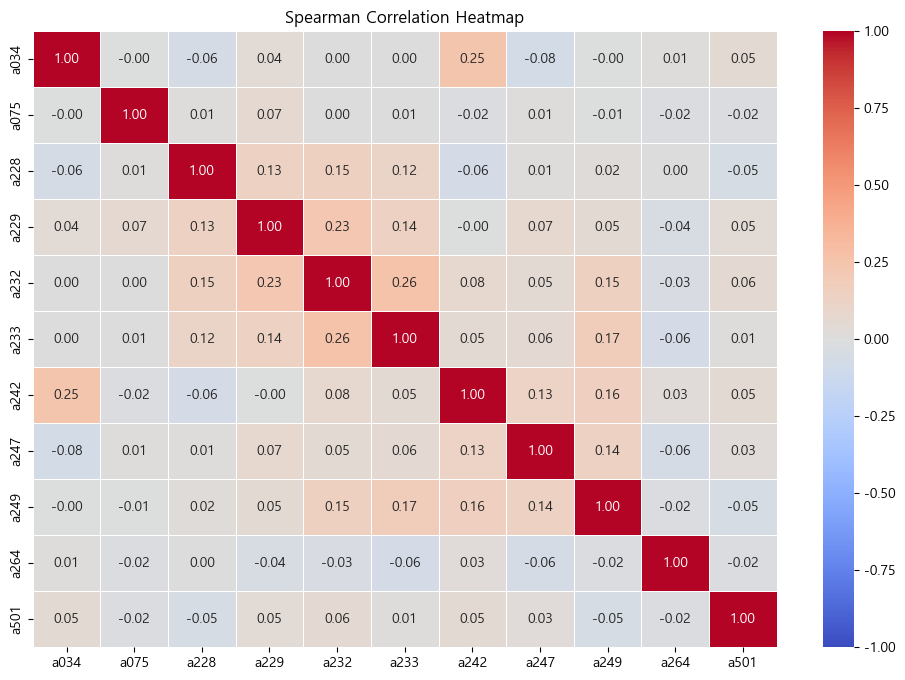

In [30]:
import seaborn as sns

corr_matrix = X.corr(method='spearman')

plt.figure(figsize=(12, 8))    
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='coolwarm', vmin=-1, center=0, linewidths=0.5)
plt.title("Spearman Correlation Heatmap")
plt.show()

In [29]:
# a225 열을 잘라내기
X = X.drop(columns='a225')

In [22]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

# Assuming `workers`, `hn4`, and `selected` are pre-defined DataFrames

# Explanation Variable List
selected_columns = selected['Column'].tolist()

# Create a binary target variable based on 'edu_difference'
workers['target'] = np.where(workers['edu_difference'] > 0, 1, 0)

# Merge workers and hn4 data
data = workers.merge(hn4, on='sampid', how='inner')

# Calculate missing data ratio
missing_data_info = data[selected_columns].isnull().mean() * 100
print("Missing Data Ratio (%):")
print(missing_data_info)

# Remove variables with more than 20% missing data
threshold = 100.0
columns_to_keep = missing_data_info[missing_data_info < threshold].index.tolist()

print("\nVariables retained after removing those with over 20% missing data:")
print(columns_to_keep)

# Set independent and dependent variables
X = data[columns_to_keep]
y = data['target']

Missing Data Ratio (%):
a034    54.870941
a075    60.149875
a225    77.685262
a228    80.482931
a229    77.685262
a232    77.685262
a233    77.685262
a242    84.912573
a247    66.044963
a249    66.044963
a264    66.044963
a501    55.237302
dtype: float64

Variables retained after removing those with over 20% missing data:
['a034', 'a075', 'a225', 'a228', 'a229', 'a232', 'a233', 'a242', 'a247', 'a249', 'a264', 'a501']


In [49]:
import statsmodels.api as sm
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

X = X.dropna()

X.head()

,a034,a075,a225,a228,a229,a232,a233,a242,a247,a249,a264,a501
15,5.0,2.0,2.0,2.0,2.0,1.0,2.0,3.0,10.0,2.0,5.0,2.0
27,1.0,2.0,1.0,2.0,2.0,1.0,2.0,4.0,9.0,2.0,4.0,2.0
36,3.0,2.0,2.0,2.0,2.0,1.0,2.0,3.0,10.0,4.0,4.0,1.0
55,2.0,2.0,2.0,1.0,1.0,1.0,1.0,2.0,10.0,3.0,5.0,2.0
68,3.0,2.0,2.0,2.0,2.0,1.0,2.0,0.0,6.0,1.0,4.0,2.0


In [50]:
selected_columns

['a034',
 'a075',
 'a225',
 'a228',
 'a229',
 'a232',
 'a233',
 'a242',
 'a247',
 'a249',
 'a264',
 'a501']

In [55]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

# 가정: X와 y가 정의되고 정리되어 있음
X = X.dropna()
y = y.loc[X.index]

# 종속 변수에 결측치가 없는지 확인
assert not y.isnull().any(), "종속 변수 y에 결측치가 존재합니다."

independent_vars = ['a034', 'a075', 'a228', 'a229', 'a233', 'a242', 'a247', 'a249', 'a501']
continuous_vars = ['a264']

# 범주형 변수로 변환 후 더미 변수로 변환
for column in independent_vars:
    X[column] = X[column].astype('category')

X_dummies = pd.get_dummies(X[independent_vars], drop_first=True)

# 연속형 변수를 더미 변환된 데이터프레임에 추가
X_combined = pd.concat([X_dummies, X[continuous_vars]], axis=1)

# 데이터 형식 확인 및 변환
# 연속형 변수는 float으로 유지, 더미 변수는 int로 변환
for column in X_combined.columns:
    if column in continuous_vars:
        X_combined[column] = X_combined[column].astype(float)
    else:
        X_combined[column] = X_combined[column].astype(int)

# 상수 추가
X_const = sm.add_constant(X_combined)

# 로지스틱 회귀 모델 피팅
logit_model = sm.Logit(y, X_const)
result = logit_model.fit()

# 모델 요약
print("\n로지스틱 회귀 모델 요약:")
print(result.summary())


Optimization terminated successfully.
         Current function value: 0.566012
         Iterations 7

로지스틱 회귀 모델 요약:
                           Logit Regression Results                           
Dep. Variable:                 target   No. Observations:                  464
Model:                          Logit   Df Residuals:                      427
Method:                           MLE   Df Model:                           36
Date:                Sun, 04 Aug 2024   Pseudo R-squ.:                  0.1214
Time:                        13:25:45   Log-Likelihood:                -262.63
converged:                       True   LL-Null:                       -298.90
Covariance Type:            nonrobust   LLR p-value:                 0.0002929
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -2.7159      1.887     -1.440      0.150      -6.413       0.982
a034_2       